Some Visualizations for Raw Data

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm

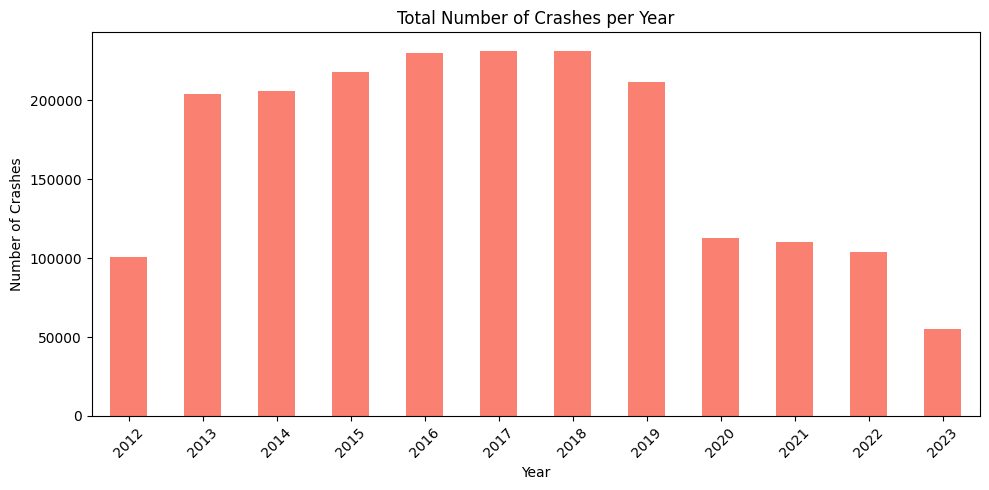

In [33]:
crashes = pd.read_csv("NYC Vehicle Crashes 2012 - 2023.csv", low_memory=False)
crashes['CRASH DATE'] = pd.to_datetime(crashes['CRASH DATE'], errors='coerce')
crashes['year'] = crashes['CRASH DATE'].dt.year

yearly_crashes = crashes.groupby('year').size()

plt.figure(figsize=(10, 5))
yearly_crashes.plot(kind='bar', color='salmon')
plt.title("Total Number of Crashes per Year")
plt.xlabel("Year")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

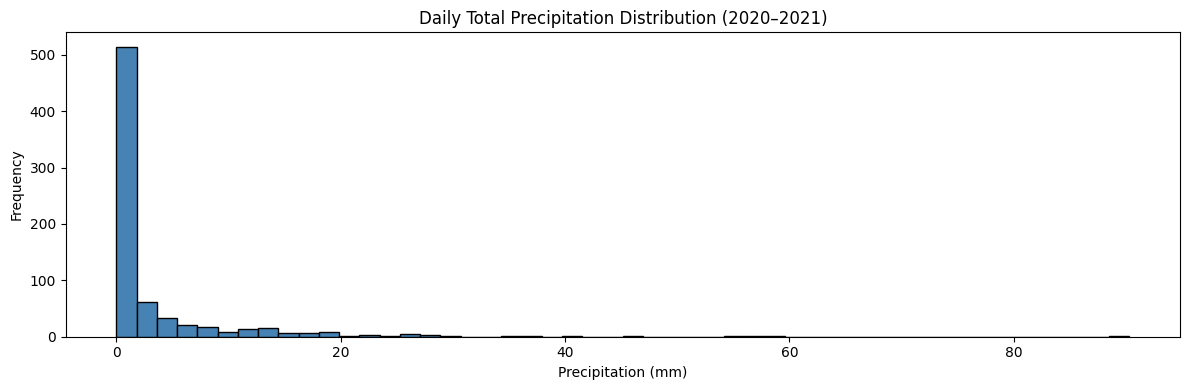

In [34]:
weather_hourly = pd.read_csv("NYC_Weather_2016_2022.csv")
weather_hourly['time'] = pd.to_datetime(weather_hourly['time'], errors='coerce')
weather_hourly = weather_hourly[
    (weather_hourly['time'] >= '2020-01-01') & (weather_hourly['time'] <= '2021-12-31')
]
weather_hourly.rename(columns={'precipitation (mm)': 'precipitation'}, inplace=True)
weather_hourly['precipitation'] = pd.to_numeric(weather_hourly['precipitation'], errors='coerce')
weather_hourly['date'] = weather_hourly['time'].dt.date

daily_precip = weather_hourly.groupby('date')['precipitation'].sum()

plt.figure(figsize=(12, 4))
plt.hist(daily_precip, bins=50, color='steelblue', edgecolor='black')
plt.title("Daily Total Precipitation Distribution (2020–2021)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Data Loading / Data Cleaning / Data Enrichment

In [35]:
# 1. Load and process crash data (2019–2021)
crashes = pd.read_csv("NYC Vehicle Crashes 2012 - 2023.csv", low_memory=False)
crashes['CRASH DATE'] = pd.to_datetime(crashes['CRASH DATE'], errors='coerce')
crashes = crashes[(crashes['CRASH DATE'] >= '2019-01-01') & (crashes['CRASH DATE'] <= '2021-12-31')]
crash_counts = crashes.groupby('CRASH DATE').size().reset_index(name='num_crashes')  # daily crash count

# 2. Load and process 2019 weather data
weather_2019 = pd.read_csv("nyc_temperature.csv")
weather_2019['date'] = pd.to_datetime(weather_2019['date'], format='%d/%m/%Y', errors='coerce')
weather_2019.rename(columns=lambda x: x.strip().lower(), inplace=True)
weather_2019.rename(columns={
    'tavg': 'tavg',
    'precipitation': 'precipitation'
}, inplace=True)

# Convert values to numeric data and group them by date
for col in ['tavg', 'precipitation']:
    if col in weather_2019.columns:
        weather_2019[col] = pd.to_numeric(weather_2019[col], errors='coerce')
weather_2019_daily = weather_2019.groupby('date')[['tavg', 'precipitation']].mean().reset_index()

# 3. Load and process 2020–2021 weather data
weather_2020_2021 = pd.read_csv("NYC_Weather_2016_2022.csv")
weather_2020_2021['time'] = pd.to_datetime(weather_2020_2021['time'], errors='coerce')
weather_2020_2021 = weather_2020_2021[(weather_2020_2021['time'] >= '2020-01-01') & (weather_2020_2021['time'] <= '2021-12-31')]
weather_2020_2021.rename(columns={
    'temperature_2m (°C)': 'tavg',
    'precipitation (mm)': 'precipitation'
}, inplace=True)
weather_2020_2021['date'] = pd.to_datetime(weather_2020_2021['time'].dt.date)
weather_2020_2021_daily = weather_2020_2021.groupby('date')[['tavg', 'precipitation']].mean().reset_index()

# 4. Combine weather data into one DataFrame
weather_combined = pd.concat([weather_2019_daily, weather_2020_2021_daily], ignore_index=True)

# 5. Merge crash and weather data
final_df = pd.merge(crash_counts, weather_combined, left_on='CRASH DATE', right_on='date', how='left')
final_df.fillna(final_df.mean(numeric_only=True), inplace=True)  # fill missing weather data
final_df.drop(columns=['date'], inplace=True)
final_df.dropna(inplace=True)  # drops remaining NaNs

# 6. Create new useful columns (enrichment)
# Label bad weather days (rain > 3mm or temperature < 0°C)
final_df['bad_weather'] = ((final_df['precipitation'] > 3) | (final_df['tavg'] < 0)).astype(int)

# Categorizing temperature levels
def categorize_temp(temp):
    if temp < 0:
        return 'Very Cold'
    elif temp < 10:
        return 'Cold'
    elif temp < 20:
        return 'Mild'
    else:
        return 'Warm'
final_df['temp_category'] = final_df['tavg'].apply(categorize_temp)

# Mark if the crash occurred on a weekend
final_df['is_weekend'] = final_df['CRASH DATE'].dt.weekday.isin([5, 6]).astype(int)



Pearson correlation test (precipitation vs crash count)

In [36]:
correlation, p_value = pearsonr(final_df['precipitation'], final_df['num_crashes'])
print("Pearson correlation coefficient:", correlation)
print("P-value:", p_value)

if p_value < 0.05:
    print("\n There is a significant correlation between precipitation and number of crashes.")
else:
    print("\n There is no significant correlation between precipitation and number of crashes.")

Pearson correlation coefficient: -0.020131536370155117
P-value: 0.5055521174322265

 There is no significant correlation between precipitation and number of crashes.


Data visualizations

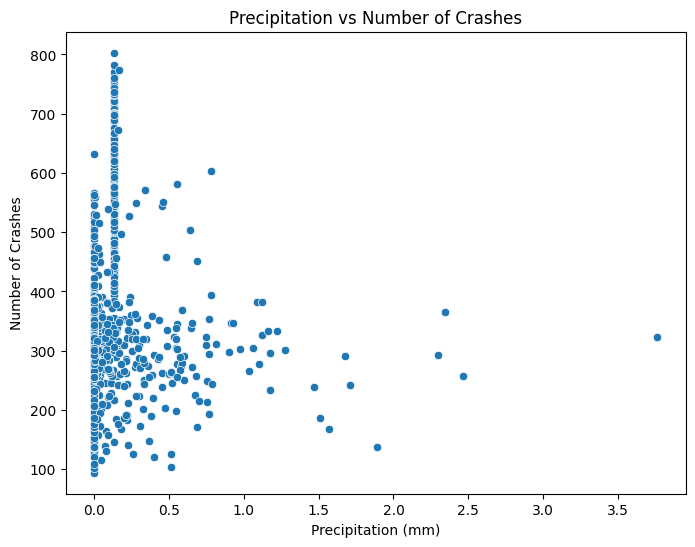

In [37]:
# Scatter: Precipitation vs Crashes
plt.figure(figsize=(8, 6))
sns.scatterplot(x='precipitation', y='num_crashes', data=final_df)
plt.title('Precipitation vs Number of Crashes')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Number of Crashes')
plt.show()

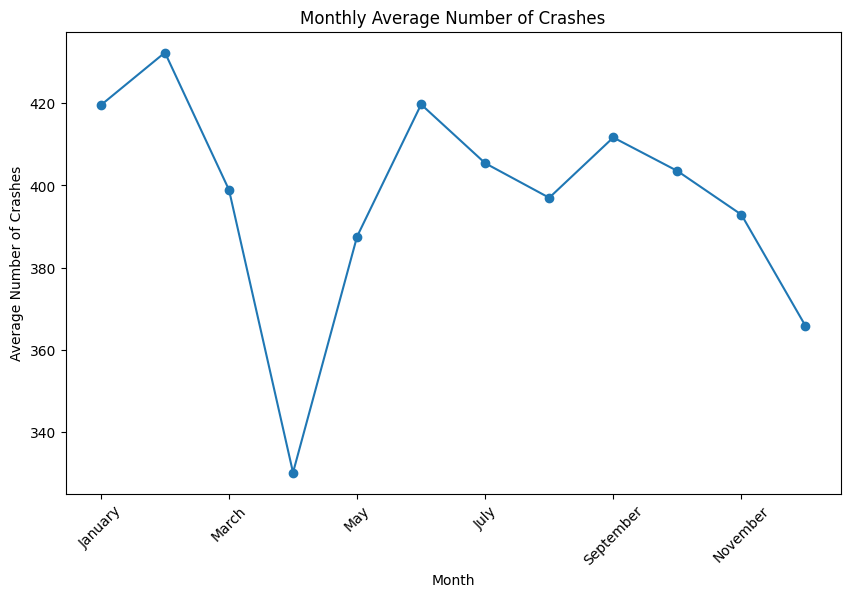

In [38]:
# Line: Monthly Average Crashes
plt.figure(figsize=(10, 6))
final_df['month'] = final_df['CRASH DATE'].dt.month_name()
monthly_avg = final_df.groupby('month')['num_crashes'].mean().reindex([
    'January','February','March','April','May','June','July','August','September','October','November','December'
])
monthly_avg.plot(kind='line', marker='o')
plt.title('Monthly Average Number of Crashes')
plt.xlabel('Month')
plt.ylabel('Average Number of Crashes')
plt.xticks(rotation=45)
plt.show()

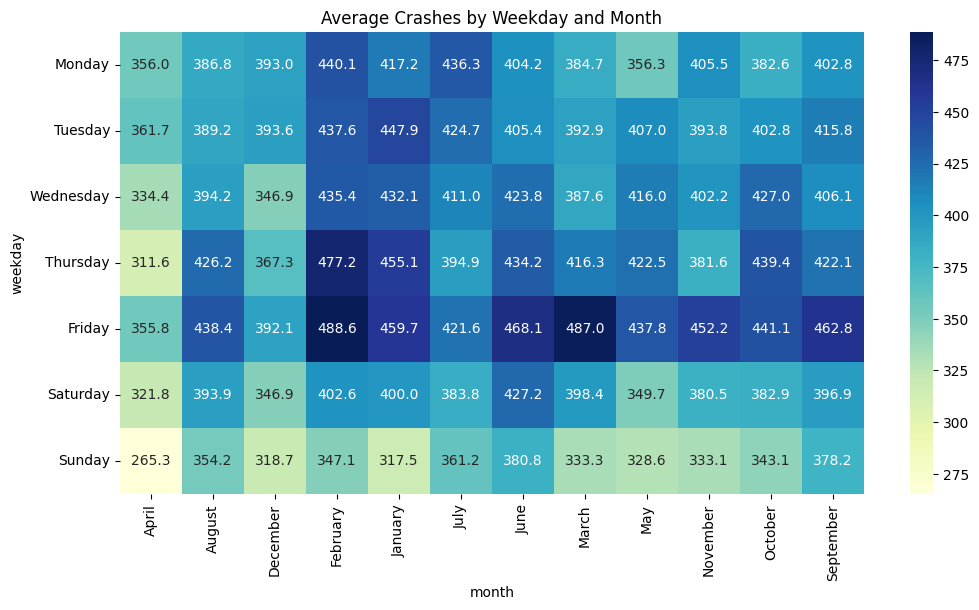

In [39]:
# Heatmap: Average Crashes by Weekday and Month
plt.figure(figsize=(12, 6))
final_df['weekday'] = final_df['CRASH DATE'].dt.day_name()
pivot_table = final_df.pivot_table(index='weekday', columns='month', values='num_crashes', aggfunc='mean')
pivot_table = pivot_table.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Average Crashes by Weekday and Month')
plt.show()


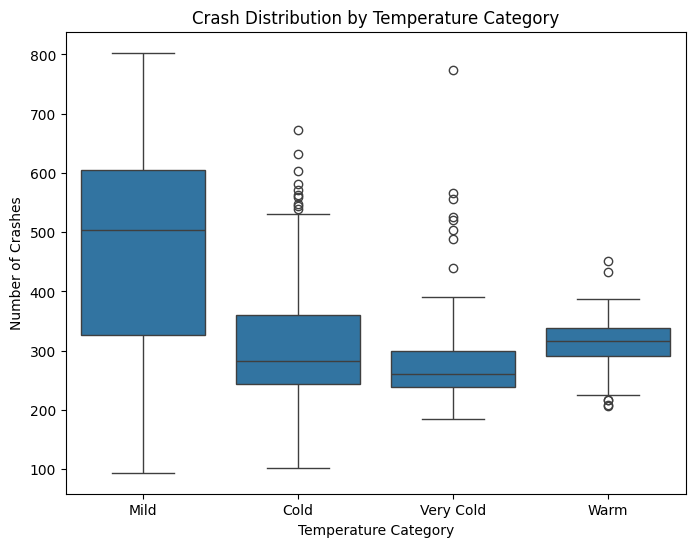

In [40]:
# Boxplot: Crashes by Temperature Category
plt.figure(figsize=(8, 6))
sns.boxplot(x='temp_category', y='num_crashes', data=final_df)
plt.title('Crash Distribution by Temperature Category')
plt.xlabel('Temperature Category')
plt.ylabel('Number of Crashes')
plt.show()